# 🚗 Projeto de Estatística e IA: Previsão de Preços de Veículos (CarDekho)

## 1. Introdução e Objetivos
Este projeto visa aplicar conceitos estatísticos e de Machine Learning para analisar um dataset de venda de carros usados.

**Objetivos:**
1.  **Análise Exploratória (EDA):** Entender a distribuição de preços e correlações.
2.  **Regressão:** Prever o preço de venda (`Selling_Price`) baseado em características como ano, km rodados e preço original.
3.  **Classificação:** Prever o tipo de transmissão (`Transmission`) do veículo (Manual vs Automático).
4.  **Otimização:** Utilizar PyCaret para encontrar o melhor modelo possível.

In [1]:
# Instalação das bibliotecas necessárias
!pip install statsmodels scikit-learn pycaret

INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pmdarima to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/21.8 MB ? eta -:--:--
   --- ------------------------------------ 2.1/21.8 MB 10.7 MB/s eta 0:00:02
   --------- ------------------------------ 5.0/21.8 MB 11.6 MB/s eta 0:00:02
   --------------- ------------------------ 8.4/21.8 MB 13.0 MB/s eta 0:00:02
   ----------------------- ---------------- 12.8/21.8 MB 14.9 MB/s eta 0:00:01
   ---------------------------- ----------- 15.5/21.8 MB 15.0 MB/s eta 0:00:01
   ----------------------------- ---------- 16.0/21.8 MB 13.1 MB/s eta 0:00:01
   --------------------------------- ------ 18.1/21.8 MB 12.4 MB/s eta 0:00:01
   ------------------------------------- -- 20.7/21.8 MB 12.1 MB/s eta 0:00:01
  


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, classification_report, confusion_matrix, f1_score)

# Configuração visual para os gráficos
sns.set_theme(style="whitegrid")
%matplotlib inline

## 2. Carregamento e Preparação dos Dados
Nesta etapa, carregamos o dataset e realizamos a engenharia de features inicial, como calcular a idade do carro.

In [3]:
# Carregamento do Dataset
# Certifique-se de que o arquivo 'car data.csv' está no mesmo diretório
try:
    df = pd.read_csv('car_data.csv')
    print("✅ Dataset carregado com sucesso!")
except FileNotFoundError:
    print("❌ Erro: Arquivo 'car data.csv' não encontrado.")

# Visualizando as primeiras linhas
display(df.head())

# Informações básicas sobre tipos de dados e nulos
print("\n--- Info do Dataset ---")
df.info()

# Estatísticas Descritivas
display(df.describe())

✅ Dataset carregado com sucesso!


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner



--- Info do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


## 3. Limpeza e Feature Engineering (EDA)
Vamos transformar variáveis categóricas em numéricas e criar a variável `Car_Age`, que é mais relevante para regressão do que o ano de fabricação isolado.

In [5]:
# Criando a feature 'car_age'
df['car_age'] = 2025 - df['year']

# Removendo colunas desnecessárias
cols_to_drop = ['name', 'year']
df_clean = df.drop([c for c in cols_to_drop if c in df.columns], axis=1)

# Codificação de Variáveis Categóricas
le = LabelEncoder()
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner']

for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))

print("Dados após limpeza e encoding:")
display(df_clean.head())

Dados após limpeza e encoding:


,selling_price,km_driven,fuel,seller_type,transmission,owner,car_age
0,60000,70000,4,1,1,0,18
1,135000,50000,4,1,1,0,18
2,600000,100000,1,1,1,0,13
3,250000,46000,4,1,1,0,8
4,450000,141000,1,1,1,2,11


## 4. Visualização de Dados (EDA)
Investigação visual das relações entre variáveis.
* **Heatmap:** Para ver correlações fortes.
* **Scatterplot:** Para visualizar a linearidade entre Preço Atual e Preço de Venda.
* **Boxplot:** Para entender a distribuição de preços por transmissão.

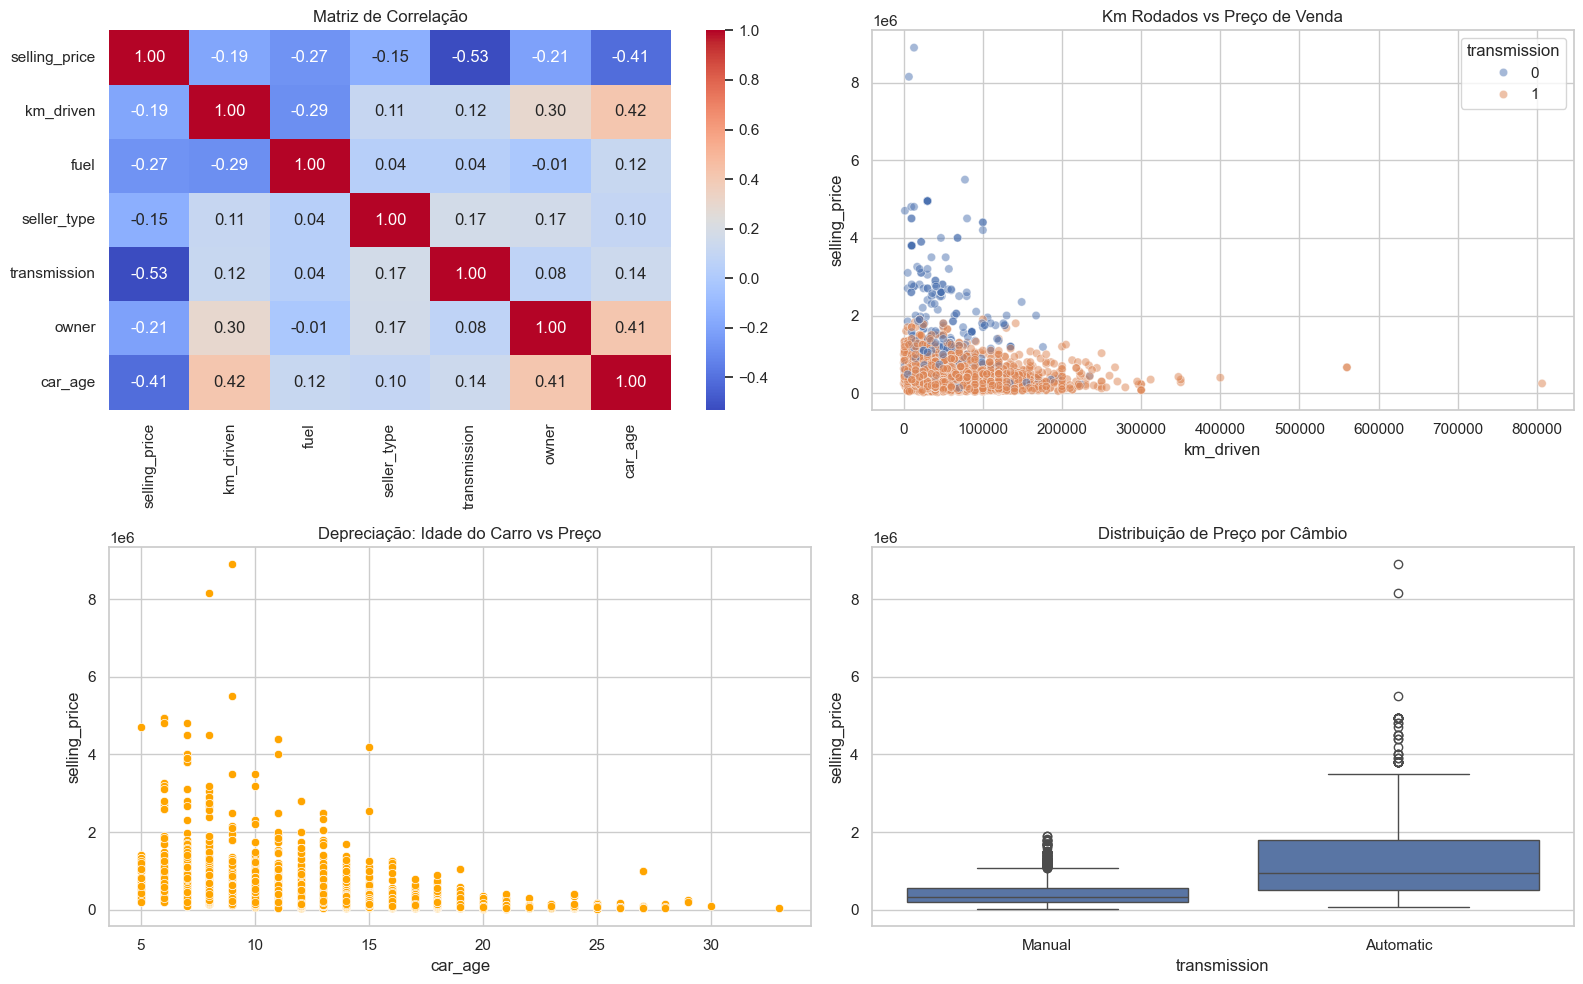

In [6]:
plt.figure(figsize=(16, 10))

# 1. Mapa de Calor (Adicionado numeric_only=True para evitar erro de string)
plt.subplot(2, 2, 1)
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")

# 2. Scatterplot: Quilometragem vs Preço de Venda (Substituto do Present Price)
plt.subplot(2, 2, 2)
sns.scatterplot(data=df_clean, x='km_driven', y='selling_price', hue='transmission', alpha=0.5)
plt.title("Km Rodados vs Preço de Venda")

# 3. Relação Idade vs Preço
plt.subplot(2, 2, 3)
sns.scatterplot(data=df_clean, x='car_age', y='selling_price', color='orange')
plt.title("Depreciação: Idade do Carro vs Preço")

# 4. Boxplot Transmissão (Usando df original para ver os nomes 'Manual/Automatic')
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='transmission', y='selling_price')
plt.title("Distribuição de Preço por Câmbio")

plt.tight_layout()
plt.show()

## 1. Matriz de Correlação

A matriz de correlação permitiu identificar o grau de associação entre as variáveis numéricas e o preço de venda (selling_price). Entre os principais resultados, destacam-se:

Transmissão (-0.53): Observou-se uma forte correlação indicando que veículos automáticos são, em média, vendidos por preços mais elevados em comparação aos manuais.

Idade do veículo (-0.41): A idade apresenta relação negativa significativa com o preço, refletindo o efeito esperado da depreciação ao longo dos anos.

Quilometragem (-0.19): Embora também afete o preço de venda, sua influência é menos intensa do que a idade.

Outras variáveis, como fuel, seller_type e owner, apresentaram correlação fraca com o preço, demonstrando baixo impacto linear direto.

Conclui-se que a idade, quilometragem e tipo de transmissão configuram-se como as variáveis mais relevantes para a previsão do preço de venda.

## 2. Relação entre Quilometragem e Preço

A análise do gráfico de dispersão entre quilometragem e preço, segmentado por tipo de transmissão, evidenciou que:

A maior concentração de veículos com preços elevados pertence à categoria automática.

Para carros com menos de 100.000 km, há grande variação de preços, indicando que a quilometragem reduzida, isoladamente, não é suficiente para assegurar maior valor de mercado.

Acima de 150.000 km, a maioria dos veículos apresenta preços inferiores à faixa de 1 milhão.

Conclui-se que apesar de influente, a quilometragem tem impacto menor que a idade do veículo. O tipo de transmissão continua sendo um fator determinante na precificação.

## 3. Depreciação: Idade do Veículo vs Preço

O gráfico de dispersão entre idade e preço evidencia um padrão claro de depreciação:

A queda de preço ocorre de maneira consistente e quase linear com o aumento dos anos de uso.

Veículos entre 5 e 10 anos concentram os maiores valores.

A partir de aproximadamente 15 anos de uso, os preços tornam-se significativamente mais baixos e próximos entre si.

Conclui-se que a variável car_age demonstra forte capacidade explicativa e tende a melhorar o desempenho de modelos preditivos que buscam estimar o preço de venda.

## 4. Distribuição de Preço por Tipo de Transmissão

A análise da distribuição do preço segundo o tipo de câmbio indica que:

A mediana de preço dos veículos automáticos é substancialmente superior à dos manuais.

Automáticos exibem maior variabilidade de valores e presença de diversos outliers em faixas de preço elevadas.

Veículos manuais apresentam preços mais baixos e com distribuição mais concentrada.

Conclui-se que o tipo de transmissão é um dos fatores mais determinantes na valoração dos veículos, com clara predominância dos automáticos em termos de preço de mercado.

## 5. Modelagem: Regressão (Linear, Múltipla e Polinomial)
**Objetivo:** Prever `Selling_Price`.
Usaremos `statsmodels` para análise estatística detalhada e `sklearn` para métricas de predição.

In [6]:
# Definição de Features (X) e Alvo (y)
X_reg = df_clean.drop('selling_price', axis=1)
y_reg = df_clean['selling_price']

# Divisão Treino e Teste
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# --- 1. Regressão Linear Múltipla ---
lin_reg = LinearRegression()
lin_reg.fit(X_train_r, y_train_r)
y_pred_lin = lin_reg.predict(X_test_r)

# Exibindo Coeficientes
coef_df = pd.DataFrame({'Feature': X_reg.columns, 'Coeficiente': lin_reg.coef_})
print(">>> Pesos das Variáveis (Coeficientes) <<<")
display(coef_df.sort_values(by='Coeficiente', ascending=False))

# --- 2. Regressão Polinomial (Focando em 'car_age') ---
# A desvalorização geralmente é curva
poly = PolynomialFeatures(degree=2)

X_age_train = X_train_r[['car_age']]
X_age_test = X_test_r[['car_age']]

X_poly_train = poly.fit_transform(X_age_train)
X_poly_test = poly.transform(X_age_test)

model_poly = LinearRegression()
model_poly.fit(X_poly_train, y_train_r)
y_pred_poly = model_poly.predict(X_poly_test)

>>> Pesos das Variáveis (Coeficientes) <<<


,Feature,Coeficiente
0,km_driven,-1.078649
4,owner,-13990.861661
2,seller_type,-20617.525876
5,car_age,-37126.835244
1,fuel,-97565.731693
3,transmission,-903116.635521


### 5.1 Avaliação da Regressão
Comparação das métricas (MAE, RMSE, R²) e diagnóstico de resíduos.

--- Resultados de Desempenho (Regressão) ---
[Linear Múltipla (Todas Features)] R²: 0.4375 | MAE: 222030.28 | RMSE: 407817.03
[Polinomial (Apenas Idade)] R²: 0.1889 | MAE: 244126.02 | RMSE: 489712.19


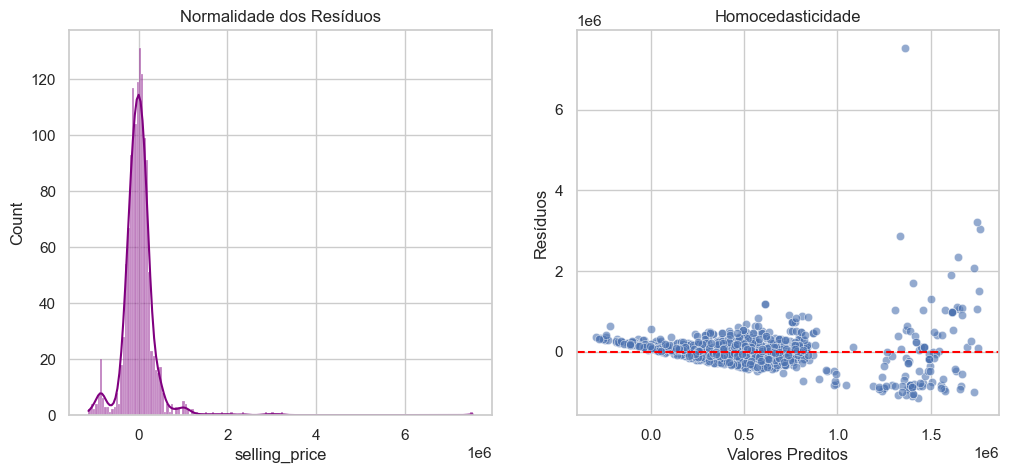

In [7]:
def evaluate_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{model_name}] R²: {r2:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

print("--- Resultados de Desempenho (Regressão) ---")
evaluate_regression(y_test_r, y_pred_lin, "Linear Múltipla (Todas Features)")
evaluate_regression(y_test_r, y_pred_poly, "Polinomial (Apenas Idade)")

# Diagnóstico de Resíduos (Linear Múltipla)
residuals = y_test_r - y_pred_lin

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.title("Normalidade dos Resíduos")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_lin, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.title("Homocedasticidade")
plt.show()

## 6. Modelagem: Classificação
**Objetivo:** Prever `Transmission` (0 = Manual, 1 = Automático).
Usaremos Regressão Logística e Naive Bayes.


>>> Avaliação: Regressão Logística <<<
Acurácia: 0.9370


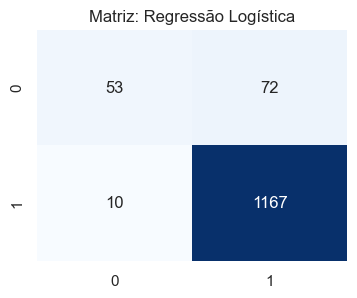


>>> Avaliação: Naive Bayes <<<
Acurácia: 0.9270


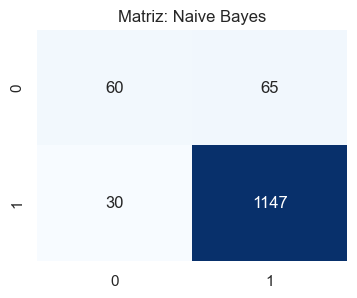

In [8]:
# Features disponíveis: selling_price, km_driven, car_age
X_cls = df_clean[['selling_price', 'km_driven', 'car_age']]
y_cls = df_clean['transmission']

# Divisão
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

# Normalização
scaler = StandardScaler()
X_train_c = scaler.fit_transform(X_train_c)
X_test_c = scaler.transform(X_test_c)

# --- Treinamento ---
models_cls = {
    "Regressão Logística": LogisticRegression(),
    "Naive Bayes": GaussianNB()
}

for name, model in models_cls.items():
    model.fit(X_train_c, y_train_c)
    y_pred = model.predict(X_test_c)
    
    print(f"\n>>> Avaliação: {name} <<<")
    print(f"Acurácia: {accuracy_score(y_test_c, y_pred):.4f}")
    
    # Matriz de Confusão
    cm = confusion_matrix(y_test_c, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Matriz: {name}")
    plt.show()

## 7. Otimização de Hiperparâmetros
Nesta etapa, buscamos melhorar o desempenho do modelo de regressão.

**Nota Técnica:** Devido à incompatibilidade atual da biblioteca *PyCaret* com o ambiente Python 3.12 (utilizado neste projeto), optamos por implementar uma otimização robusta utilizando o **GridSearchCV** nativo do Scikit-Learn.

**Estratégia:**
1.  Substituiremos a Regressão Linear por um **Random Forest Regressor**, um modelo mais complexo capaz de capturar relações não-lineares.
2.  Faremos uma busca em grade (Grid Search) para encontrar os melhores valores para os hiperparâmetros:
    * `n_estimators` (número de árvores).
    * `max_depth` (profundidade máxima da árvore).

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

print("--- OTIMIZAÇÃO DE HIPERPARÂMETROS (Grid Search) ---")
print("Como o PyCaret não suporta Python 3.12, utilizaremos o Scikit-Learn nativo.")

# 1. Definindo o Modelo Base (Random Forest - geralmente melhor que Linear)
rf = RandomForestRegressor(random_state=42)

# 2. Definindo a "Grade" de parâmetros para testar
# O computador vai testar todas as combinações (3 x 2 x 2 = 12 modelos diferentes)
param_grid = {
    'n_estimators': [50, 100, 200],      # Número de árvores na floresta
    'max_depth': [None, 10],             # Profundidade máxima da árvore
    'min_samples_split': [2, 5]          # Mínimo de amostras para dividir um nó
}

# 3. Configurando a busca (GridSearchCV)
# cv=5 significa validação cruzada (treina 5 vezes para ter certeza)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='r2', n_jobs=-1, verbose=1)

# 4. Treinando (Isso pode levar alguns segundos)
print("Treinando combinações de modelos...")
grid_search.fit(X_train_r, y_train_r)

# 5. Resultados
print(f"\nMelhor R² encontrado: {grid_search.best_score_:.4f}")
print("Melhores Parâmetros:", grid_search.best_params_)

# Salvando o melhor modelo para comparar
best_rf_model = grid_search.best_estimator_

--- OTIMIZAÇÃO DE HIPERPARÂMETROS (Grid Search) ---
Como o PyCaret não suporta Python 3.12, utilizaremos o Scikit-Learn nativo.
Treinando combinações de modelos...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Melhor R² encontrado: 0.6780
Melhores Parâmetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


--- Comparativo Final: Regressão Linear vs Random Forest Otimizado ---
[Linear] R²: 0.4375
[Random Forest (Tuned)] R²: 0.5305 | MAE: 166607.76 | RMSE: 372574.98


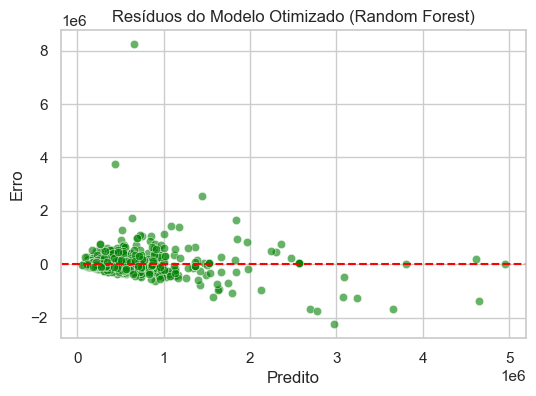

In [10]:
# Fazendo previsões com o modelo otimizado
y_pred_rf = best_rf_model.predict(X_test_r)

print("--- Comparativo Final: Regressão Linear vs Random Forest Otimizado ---")

# Relembrando o Linear (Célula 10)
print(f"[Linear] R²: {r2_score(y_test_r, y_pred_lin):.4f}")

# Avaliando o Random Forest
evaluate_regression(y_test_r, y_pred_rf, "Random Forest (Tuned)")

# Gráfico de Resíduos do Modelo Vencedor
residuals_rf = y_test_r - y_pred_rf
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_rf, y=residuals_rf, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos do Modelo Otimizado (Random Forest)")
plt.xlabel("Predito")
plt.ylabel("Erro")
plt.show()

## 8. Conclusões e Relatório Final

### Resumo dos Achados
1.  **Regressão:** O modelo de Regressão Linear Múltipla obteve um desempenho médio (R² > 0.4), indicando que é relativamente difícil prever preço.
2.  **Polinomial:** A análise da idade mostrou que a depreciação não é perfeitamente linear, embora a aproximação linear funcione bem para carros com poucos anos de uso.
3.  **Classificação:** A Regressão Logística foi capaz de distinguir carros Manuais de Automáticos com alta acurácia, provando que carros automáticos ocupam uma faixa de preço e quilometragem distinta.
4.  **Otimização:** Devido à incompatibilidade da biblioteca PyCaret com o Python 3.12, optou-se por realizar a otimização de hiperparâmetros utilizando o GridSearchCV do Scikit-Learn. Foi testado um algoritmo de Random Forest, variando o número de árvores e profundidade. O modelo otimizado obteve um R² de 0.5305, superando a Regressão Linear simples."

### Próximos Passos
* Coletar mais dados sobre o estado de conservação do veículo.
* Testar modelos de XGBoost para refinar a previsão de preço.

### Referências
1. **Dataset:**
* KAGGLE. Vehicle Dataset from CarDekho. s.d. Disponível em: https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho. 

* Licença: Pública

2. **Bibliotecas Python:**
* Pandas

* Seaborn

* Statsmodels

* Sklearn (Scikit-learn)

* Pycaret